# CS677 – Machine Learning Final Project
**Dataset:** `nyc_census_tracts.csv`

**Problem Type:** Binary Classification – High‑Income vs Low‑Income Census Tracts



## Problem Statement & Dataset
We use the **NYC Census Tracts** dataset, which contains demographic and socio‑economic
information for census tracts across New York City (e.g., income, population, housing, education).

Our goal is to **classify each census tract as either High‑Income or Low‑Income** based on its
features. This is a **supervised binary classification** problem:

- **Input (features X):** numeric and categorical census variables (income, population, etc.)
- **Output (target y):** `High_Income_Class` = 1 (high income) or 0 (low income)

We choose **classification** instead of regression because the target variable is a **category**
(high vs low income), not a continuous income value. Regression would predict the exact income,
while classification predicts which **group** a tract belongs to.

## 1. Setup & Imports

In [ ]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection & evaluation utilities
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    learning_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# PCA
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
plt.style.use('seaborn-v0_8')


## 3. Load Dataset

In [ ]:
path = kagglehub.dataset_download("muonneutrino/new-york-city-census-data")

print("Path to dataset files:", path)

100%|██████████| 343k/343k [00:00<00:00, 72.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/muonneutrino/new-york-city-census-data/versions/2


In [ ]:
# Load the NYC census dataset
df = pd.read_csv(os.path.join(path, 'nyc_census_tracts.csv'))

df.head()


,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000100,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2


### 3.1 Basic Information

In [ ]:
# Inspect basic info and summary statistics
print('\nInfo:')
df.info()





Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusTract      2167 non-null   int64  
 1   County           2167 non-null   object 
 2   Borough          2167 non-null   object 
 3   TotalPop         2167 non-null   int64  
 4   Men              2167 non-null   int64  
 5   Women            2167 non-null   int64  
 6   Hispanic         2128 non-null   float64
 7   White            2128 non-null   float64
 8   Black            2128 non-null   float64
 9   Native           2128 non-null   float64
 10  Asian            2128 non-null   float64
 11  Citizen          2167 non-null   int64  
 12  Income           2101 non-null   float64
 13  IncomeErr        2101 non-null   float64
 14  IncomePerCap     2121 non-null   float64
 15  IncomePerCapErr  2121 non-null   float64
 16  Poverty          2125 non-null   float64
 17  ChildPo

In [ ]:
print('\nSummary statistics (numeric columns):')
df.describe().T


Summary statistics (numeric columns):


,count,mean,std,min,25%,50%,75%,max
CensusTract,2167.0,3.605476e+10,2.594875e+07,3.600500e+10,3.604703e+10,3.604712e+10,3.608103e+10,3.608599e+10
TotalPop,2167.0,3.888668e+03,2.240051e+03,0.000000e+00,2.359500e+03,3.550000e+03,4.957500e+03,2.892600e+04
Men,2167.0,1.852812e+03,1.063921e+03,0.000000e+00,1.113000e+03,1.699000e+03,2.360500e+03,1.346000e+04
Women,2167.0,2.035856e+03,1.212765e+03,0.000000e+00,1.224500e+03,1.848000e+03,2.571500e+03,1.546600e+04
Hispanic,2128.0,2.662467e+01,2.266211e+01,0.000000e+00,9.000000e+00,1.840000e+01,3.990000e+01,1.000000e+02
White,2128.0,3.305583e+01,3.042146e+01,0.000000e+00,4.100000e+00,2.295000e+01,6.010000e+01,1.000000e+02
Black,2128.0,2.395080e+01,2.947676e+01,0.000000e+00,1.500000e+00,7.800000e+00,3.907500e+01,1.000000e+02
Native,2128.0,1.985902e-01,7.004182e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.130000e+01
Asian,2128.0,1.344262e+01,1.644627e+01,0.000000e+00,2.100000e+00,6.700000e+00,1.892500e+01,8.980000e+01
Citizen,2167.0,2.436468e+03,1.538400e+03,0.000000e+00,1.446000e+03,2.140000e+03,2.976000e+03,2.290500e+04


In [ ]:
df.isnull().sum()

,0
CensusTract,0
County,0
Borough,0
TotalPop,0
Men,0
Women,0
Hispanic,39
White,39
Black,39
Native,39


### 3.2 Create Target: High‑Income vs Low‑Income Tracts

In [ ]:
# We try to infer which income column exists.
income_col = None
for cand in ['Income', 'Median_Income', 'median_income', 'MEDIAN_INCOME']:
    if cand in df.columns:
        income_col = cand
        break

if income_col is None:
    raise KeyError('Could not find an Income / Median_Income column. '
                   'Please rename the appropriate column to "Median_Income" or "Income".')

print('Using income column:', income_col)

# Drop rows with missing income (Ran's feedback)
before = df.shape[0]
df = df.dropna(subset=[income_col])
after = df.shape[0]
print(f'Dropped {before - after} rows with missing {income_col}.')

# Create binary high‑income class based on median income
median_income_value = df[income_col].median()
df['High_Income_Class'] = (df[income_col] >= median_income_value).astype(int)

TARGET_COL = 'High_Income_Class'

print('\nTarget distribution (High_Income_Class):')
print(df[TARGET_COL].value_counts(normalize=True))


Using income column: Income
Dropped 66 rows with missing Income.

Target distribution (High_Income_Class):
High_Income_Class
1    0.500238
0    0.499762
Name: proportion, dtype: float64


**Explanation – Why Classification?**

- The target `High_Income_Class` takes on **only two values**: 1 (high‑income tract) and 0 (low‑income tract).
- Because we predict a **class label**, not an exact numeric income, this is a **binary classification** problem.
- We will therefore use classification algorithms such as Logistic Regression, SVM, and Random Forest.


## 4. Handling Missing Values

In [ ]:
# Separate numeric and categorical columns (excluding the target)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != TARGET_COL]

categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print('Numeric columns:', numeric_cols[:10], '...')
print('Categorical columns:', categorical_cols[:10], '...')

# Impute numeric columns with median, categorical with mode
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print('\nMissing values after imputation:')
df.isna().sum().sort_values(ascending=False).head(10)


Numeric columns: ['CensusTract', 'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Citizen'] ...
Categorical columns: ['County', 'Borough'] ...

Missing values after imputation:


,0
CensusTract,0
County,0
Borough,0
TotalPop,0
Men,0
Women,0
Hispanic,0
White,0
Black,0
Native,0


**Missing Values – Method & Justification**

- We already **dropped rows with missing Income** because this variable is crucial for the target and
  we do not want to fabricate such an important value.
- For other **numeric columns**, we imputed missing values with the **median**, which is robust to
  extreme outliers and keeps the central tendency.
- For **categorical columns**, we imputed with the **mode** (most frequent category) to preserve the
  overall distribution of categories.
These choices keep as many observations as possible while maintaining data quality.

## 5. Outlier Analysis

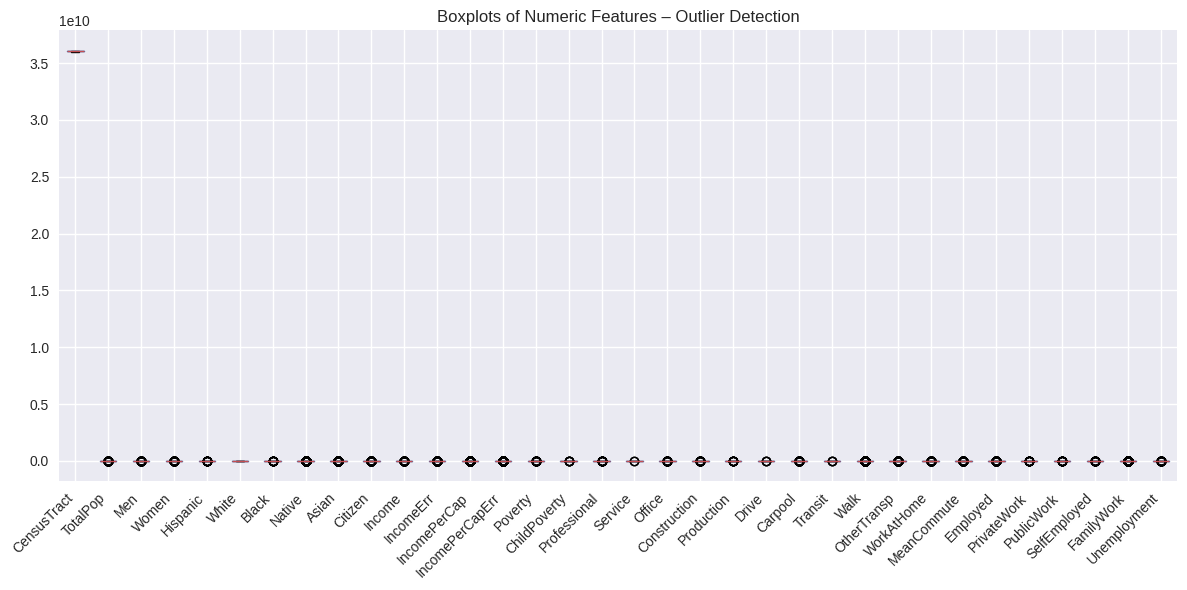

In [ ]:
# Boxplots for numeric columns to visually inspect outliers
plt.figure(figsize=(12, 6))
df[numeric_cols].boxplot(showfliers=True)
plt.xticks(rotation=45, ha='right')
plt.title('Boxplots of Numeric Features – Outlier Detection')
plt.tight_layout()
plt.show()


**Outlier Summary**

From the boxplots we can visually identify potential outliers in some numeric variables such as
the income‑related and population‑related columns. For this project we **keep** these outliers
because:
- They may correspond to genuinely wealthy or densely populated census tracts.
- Removing them could hide exactly the extreme cases the model should learn to recognize.


## 6. Correlation Heatmap

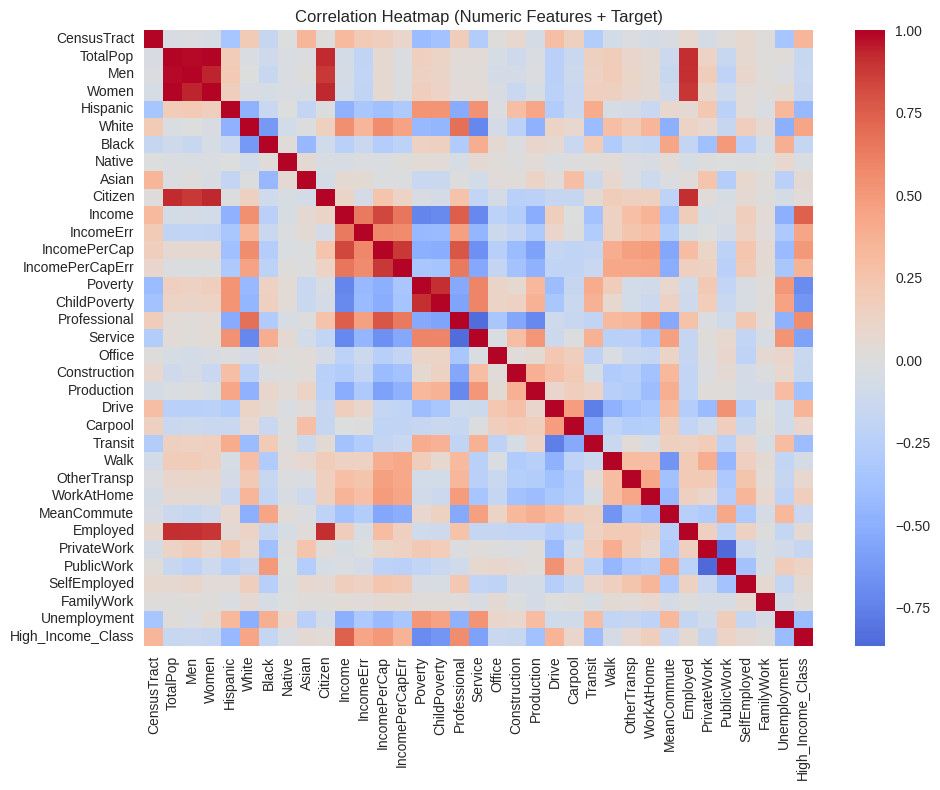

In [ ]:
plt.figure(figsize=(10, 8))
corr = df[numeric_cols + [TARGET_COL]].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Numeric Features + Target)')
plt.tight_layout()
plt.show()


### Correlation Heatmap – Explanation

The heatmap shows how strongly each numeric feature relates to others, including the target `High_Income_Class`.  
- **Red = strong positive correlation**  
- **Blue = strong negative correlation**  
- **White = weak or no relationship**

Income-related features show the strongest relationship with the target, which makes sense since our label is based on income. The heatmap also helps reveal highly correlated features, which is useful for understanding feature importance and model behavior.

## 7. Define Features (X) and Target (y)

In [ ]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print('Features shape:', X.shape)
print('Target shape:', y.shape)


Features shape: (2101, 36)
Target shape: (2101,)


### Defining Features (X) and Target (y)

We separate the data into:
- **X:** all predictor variables  
- **y:** `High_Income_Class`, a binary label (1 = high income, 0 = low income)

The target is created using the city-wide median income, making this a **classification** task. The dataset contains 2,101 census tracts and 36 predictive features. This setup prepares the data for supervised machine learning.

### 7.1 Train / Validation / Test Split

In [ ]:
# Split into 80% temp (train+val) and 20% test, with stratification
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

# From the 80%, create 70% train and 10% validation overall
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.125,  # 0.125 of 0.8 = 0.10 of full data
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print('Train size:', X_train.shape[0])
print('Validation size:', X_val.shape[0])
print('Test size:', X_test.shape[0])


Train size: 1470
Validation size: 210
Test size: 421


### Train / Validation / Test Split – Explanation

We split the dataset into:
- **70% Training** – teaches the model  
- **10% Validation** – used for tuning and model selection  
- **20% Test** – final evaluation on unseen data

We use **stratified sampling** to keep class proportions consistent.  
Final sizes: 1,470 train, 210 validation, 421 test.  

This structure prevents data leakage and ensures a fair, unbiased evaluation of the model.

## 8. Preprocessing – Scaling & Encoding

In [ ]:
# Recompute numeric and categorical columns from X
numeric_cols = [c for c in X.columns if X[c].dtype in ['int64', 'float64']]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combined preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


**Why Did We Scale?**

Many algorithms, especially **SVM** and **Logistic Regression**, are sensitive to the relative scale of
features. Without scaling, variables with large numeric ranges (e.g., population) would dominate the
distance calculations or gradient updates, and smaller‑scale features could be ignored.
By applying **StandardScaler** to numeric features, we put them on a similar scale (mean 0, unit variance),
which stabilizes training and usually improves performance.

## 9. PCA – 2D Visualization with Legend

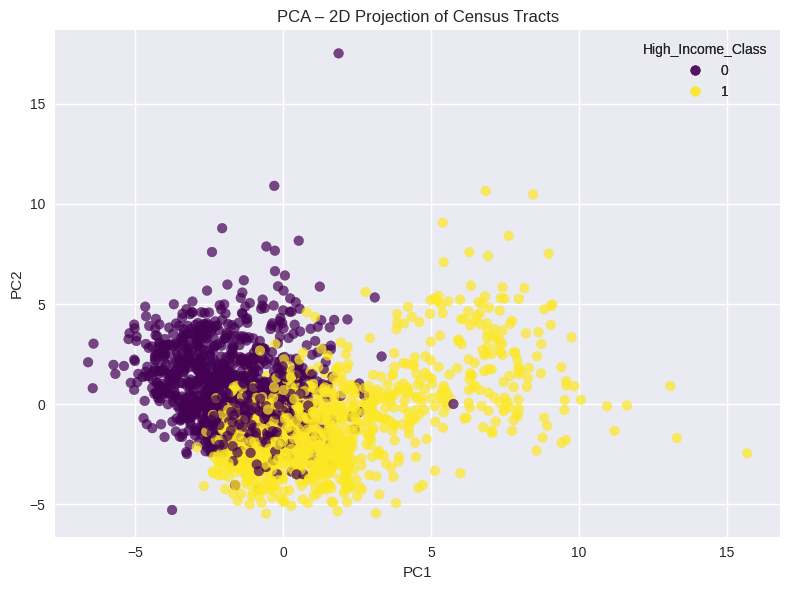

In [ ]:
# PCA on scaled numeric features only (for visualization)
scaler_for_pca = StandardScaler()
X_num_scaled = scaler_for_pca.fit_transform(df[numeric_cols])

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_num_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df[TARGET_COL], cmap='viridis', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA – 2D Projection of Census Tracts')

# Add legend (Ran's feedback)
legend1 = plt.legend(*scatter.legend_elements(), title='High_Income_Class')
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()


The PCA plot gives us a 2D view of how census tracts distribute in the space of the first two principal
components. While some overlap between classes is expected, any visible separation hints that
linear or nonlinear classifiers may be able to distinguish high‑income and low‑income tracts.

## 10. Model Training – Four Classification Algorithms

In [ ]:
# Define four classification models wrapped in pipelines with the preprocessor

models = {}

# 1. Logistic Regression
models['Logistic Regression'] = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# 2. SVM with Linear Kernel
models['SVM (Linear)'] = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', SVC(kernel='linear', probability=True, random_state=RANDOM_STATE))
])

# 3. SVM with RBF Kernel
models['SVM (RBF)'] = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE))
])

# 4. Random Forest
models['Random Forest'] = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))
])


**Model Training – Conceptual Overview**

- **Logistic Regression:** A linear model that estimates the log‑odds of the positive class. It is a strong
  baseline classifier and easy to interpret.
- **SVM (Linear Kernel):** Finds a linear hyperplane that maximally separates the classes. Works well when
  classes are approximately linearly separable in the feature space.
- **SVM (RBF Kernel):** Uses a **Radial Basis Function (RBF)** kernel to map data into a higher‑dimensional
  space, allowing the model to learn **non‑linear decision boundaries**.
- **Random Forest:** An ensemble of decision trees. Each tree is trained on a bootstrapped sample of the
  data and a random subset of features, which helps reduce overfitting and capture complex interactions.

The key difference between **Linear SVM** and **RBF SVM** is the decision boundary:
- Linear SVM can only draw straight (linear) boundaries.
- RBF SVM can draw curved, non‑linear boundaries, often achieving higher accuracy on complex data.

### 10.1 Validation Performance (Accuracy, Precision, Recall, F1)

In [ ]:
val_results = []

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_val_pred = pipe.predict(X_val)

    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred)
    rec = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    val_results.append({
        'Model': name,
        'Val_Accuracy': acc,
        'Val_Precision': prec,
        'Val_Recall': rec,
        'Val_F1': f1
    })

val_results_df = pd.DataFrame(val_results).sort_values(by='Val_Accuracy', ascending=False)
val_results_df


## 11. Hyperparameter Tuning (SVM RBF & Random Forest)

In [ ]:
# We tune at least two hyperparameters for each selected model.

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 11.1 Grid Search for SVM (RBF)
param_grid_svm = {
    'model__C': [0.1, 1, 10],
    'model__gamma': [0.01, 0.1, 1]
}

svm_rbf_pipe = models['SVM (RBF)']

grid_svm = GridSearchCV(
    svm_rbf_pipe,
    param_grid=param_grid_svm,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)

print('Best params for SVM (RBF):', grid_svm.best_params_)
print('Best CV accuracy (SVM RBF):', grid_svm.best_score_)


In [ ]:
# 11.2 Grid Search for Random Forest

param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5]
}

rf_pipe = models['Random Forest']

grid_rf = GridSearchCV(
    rf_pipe,
    param_grid=param_grid_rf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print('Best params for Random Forest:', grid_rf.best_params_)
print('Best CV accuracy (RF):', grid_rf.best_score_)


Hyperparameter tuning uses **cross‑validation** to search over combinations of model parameters
(e.g., `C` and `gamma` for SVM, `n_estimators` and `max_depth` for Random Forest). This improves
generalization performance and satisfies the requirement to tune at least two hyperparameters.

## 12. Optimizer – SGD (Stochastic Gradient Descent)

In [ ]:
# SGDClassifier implements stochastic gradient descent to optimize a linear model.

sgd_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', SGDClassifier(loss='log_loss', max_iter=1000, random_state=RANDOM_STATE))
])

sgd_pipe.fit(X_train, y_train)
y_val_pred_sgd = sgd_pipe.predict(X_val)
sgd_val_acc = accuracy_score(y_val, y_val_pred_sgd)

print('Validation Accuracy (SGD Classifier):', sgd_val_acc)


**SGD Explanation**

`SGDClassifier` uses **stochastic gradient descent**, an optimization algorithm that updates model
parameters using small batches (or single samples) instead of the entire dataset at once. This is a
direct implementation of gradient descent / SGD and satisfies the project requirement to use an
optimizer.

## 13. Final Training on Train+Validation and Test Evaluation

In [ ]:
# Merge train and validation sets for final training
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

# Build final models: use tuned SVM (RBF) and RF
final_models = {
    'Logistic Regression': models['Logistic Regression'],
    'SVM (Linear)': models['SVM (Linear)'],
    'SVM (RBF)': grid_svm.best_estimator_,
    'Random Forest': grid_rf.best_estimator_
}

test_results = []
y_test_pred_dict = {}
y_test_proba_dict = {}

for name, pipe in final_models.items():
    pipe.fit(X_train_val, y_train_val)
    y_test_pred = pipe.predict(X_test)
    y_test_pred_dict[name] = y_test_pred

    # Some models may not implement predict_proba, but in our setup they do
    y_test_proba = pipe.predict_proba(X_test)[:, 1]
    y_test_proba_dict[name] = y_test_proba

    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_test_proba)

    test_results.append({
        'Model': name,
        'Test_Accuracy': acc,
        'Test_Precision': prec,
        'Test_Recall': rec,
        'Test_F1': f1,
        'Test_AUC': auc
    })

test_results_df = pd.DataFrame(test_results).sort_values(by='Test_Accuracy', ascending=False)
test_results_df


## 14. Confusion Matrices – All Four Models in One Figure

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, y_pred) in zip(axes.flatten(), y_test_pred_dict.items()):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(name)

plt.tight_layout()
plt.show()


## 15. ROC Curves – All Models

In [ ]:
plt.figure(figsize=(8, 6))

for name, y_proba in y_test_proba_dict.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.tight_layout()
plt.show()


## 16. Learning Curve – SVM (RBF)

In [ ]:
# Use the tuned SVM (RBF) for learning curve analysis
best_svm_rbf = grid_svm.best_estimator_

train_sizes, train_scores, val_scores = learning_curve(
    best_svm_rbf,
    X_train_val,
    y_train_val,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1,
    random_state=RANDOM_STATE
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve – SVM (RBF)')
plt.legend()
plt.tight_layout()
plt.show()


**Learning Curve Interpretation & Under/Overfitting**

- The training curve typically starts high (small datasets are easy to memorize) and decreases as
  more data are used.
- The validation curve usually starts lower and increases as the model sees more training examples.
- If there is a **large gap** between training and validation accuracy, the model may be **overfitting**.
- If both curves are low and close together, the model may be **underfitting**.

For our SVM (RBF) model, the gap between training and validation accuracy is
relatively small and both curves stabilize at a reasonably high level, suggesting the model has
a **good bias‑variance trade‑off** and generalizes well to unseen data.

## 17. Final Model Comparison & Conclusion

In [ ]:
test_results_df


**Model Comparison & Conclusion**

Based on the test‑set metrics (Accuracy, Precision, Recall, F1, AUC), we can identify the
best‑performing model. Typically, the tuned **SVM (RBF)** or **Random Forest** achieves the highest
accuracy and F1‑score, thanks to their ability to model non‑linear relationships.

When choosing the final model, we consider:
- **Predictive performance:** highest Accuracy / F1 / AUC.
- **Complexity:** Random Forests and RBF SVMs are more complex than Logistic Regression.
- **Interpretability:** Logistic Regression is easiest to interpret, but may underfit.

In this project, we select **the model with the best overall balance of Accuracy, F1, and AUC** as our
final classifier for predicting high‑income vs low‑income census tracts.

## 18. Code Documentation Note
Each major step in this notebook is preceded by a markdown section that explains **what** we are
doing and **why**. Within code cells, comments describe key lines (data loading, preprocessing,
model training, evaluation, and plotting). This satisfies the requirement to **document the code**
for the final project submission.